In [ ]:
import pandas as pd
import subprocess
import os
import requests
import time
import numpy as np

# SonarQube configuration
SONAR_URL = 'http://localhost:9000'
SONAR_TOKEN = 'YOUR_SONAR_TOKEN'  # Replace with your SonarQube token  
SONAR_API_HEADERS = {'Authorization': f'Bearer {SONAR_TOKEN}'}



def get_code_smells_for_repo(repo_key):
    code_smells = {}
    total_count = 0
    page = 1
    page_size = 100
    issues_url = f"{SONAR_URL}/api/issues/search"
    
    while True:
        params = {
            'componentKeys': repo_key,
            'types': 'CODE_SMELL',
            'ps': page_size,
            'p': page
        }
        response = requests.get(issues_url, headers=SONAR_API_HEADERS, params=params)
        if response.status_code == 200:
            data = response.json()
            issues = data.get('issues', [])
            if not issues:
                break
            
            for issue in issues:
                total_count += 1
                rule = issue.get('rule', '')
                severity = issue.get('severity', 'N/A')
                tags = issue.get('tags', [])  # Fetch tags from the issue
                
                if rule:
                    if rule not in code_smells:
                        code_smells[rule] = {
                            'count': 1,
                            'severity': severity,
                            'tags': tags
                        }
                    else:
                        code_smells[rule]['count'] += 1
                        # Merge tags (avoid duplicates)
                        for t in tags:
                            if t not in code_smells[rule]['tags']:
                                code_smells[rule]['tags'].append(t)
            
            if len(issues) < page_size:
                break
            page += 1
        else:
            print(f"Failed to get issues for {repo_key}: {response.status_code} {response.text}")
            break
    
    code_smells['total'] = total_count
    return code_smells

def get_ncloc_for_repo(project_key):
    """Retrieve the non-comment lines of code (ncloc) for a project from SonarQube."""
    api_endpoint = f"{SONAR_URL}/api/measures/component"
    params = {
        "component": project_key,
        "metricKeys": "ncloc"
    }
    response = requests.get(api_endpoint, headers=SONAR_API_HEADERS, params=params)
    if response.status_code == 200:
        data = response.json()
        measures = data.get('component', {}).get('measures', [])
        for m in measures:
            if m.get('metric') == 'ncloc':
                try:
                    return int(m.get('value', 0))
                except ValueError:
                    return 0
    else:
        print(f"Failed to get ncloc for {project_key}: {response.status_code} {response.text}")
    return 0

def create_csv_report(data, output_path):
    """
    Create a CSV where each row represents a repository and the columns include:
      - Repository Name, Repository URL, AI Status, ncloc, Number of Commits, Total Code Smells,
      - Code Smells per KLOC,
      - And one column for each built-in rule tag (with the count of issues for that tag).
    """
    # Compute the union of all tags from all repositories.
    all_tags = set()
    for repo in data:
        for rule, details in repo['code_smells'].items():
            if rule == 'total':
                continue
            tags = details.get('tags', [])
            for t in tags:
                all_tags.add(t)
    all_tags = sorted(all_tags)  # Sorted list of tags

    # Prepare rows for CSV
    rows = []
    for repo in data:
        row = {}
        row['Repository Name'] = repo['name']
        row['Repository URL'] = repo['url']
        row['AI Status'] = repo['is_ai_coauthored']
        row['ncloc'] = repo.get('ncloc', 'Unknown')
        row['Number of Commits'] = repo.get('commits', 'Unknown')
        row['Total Code Smells'] = repo['code_smells'].get('total', 0)
        # Compute Code Smells per KLOC if ncloc is available and > 0
        # try:
        #     ncloc = float(repo.get('ncloc', 0))
        #     row['SmellsPerKLOC'] = repo['code_smells'].get('total', 0) / (ncloc / 1000) if ncloc > 0 else 0
        # except (ValueError, ZeroDivisionError):
        #     row['SmellsPerKLOC'] = 0

        # Initialize each tag column with 0
        for tag in all_tags:
            row[tag] = 0
        
        # For each code smell (rule) in the repo, add its count to each corresponding tag
        for rule, details in repo['code_smells'].items():
            if rule == 'total':
                continue
            count = details.get('count', 0)
            tags = details.get('tags', [])
            for t in tags:
                row[t] += count
        rows.append(row)
    
    df = pd.DataFrame(rows)
    df.to_csv(output_path, index=False)
    print(f"CSV report generated: {output_path}")

def main():
    base_dir = os.getcwd()
    # Update the path to your dataset file if needed
    dataset_path = '/Users/prateekbalani/Downloads/DataSet-MSR-AICoauthored - Dataset-4.csv'
    df = pd.read_csv(dataset_path)
    df = df.dropna(subset=['Repository Link'])
    print(df.head())
    
    analysis_results = []
    total_repos = len(df)
    
    for index, row in df.iterrows():
        repo_url = row['Repository Link'].strip()
        repo_name = row['Repository Name'].strip()
        # Generate a unique project key based on repo name (replace spaces with underscores)
        project_key = repo_name.replace(" ", "_")
        local_dir = f'/tmp/{repo_name}'
        
        print(f"Processing repository {index+1}/{total_repos}: {repo_name}")
        print(f"AI Status: {row['Human/AI-Coauthored']}")
        
        # Clone the repository
        try:
            subprocess.run(['git', 'clone', repo_url, local_dir], check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error cloning {repo_name}: {e}")
            continue

        # Run sonar-scanner in the repository directory
        try:
            os.chdir(local_dir)
            sonar_properties = [
                f'-Dsonar.projectKey={project_key}',
                f'-Dsonar.projectName={repo_name}',
                '-Dsonar.sources=.',
                f'-Dsonar.host.url={SONAR_URL}',
                f'-Dsonar.token={SONAR_TOKEN}'
            ]
            try:
                subprocess.run(['sonar-scanner'] + sonar_properties, check=True)
            except subprocess.CalledProcessError as e:
                print(f"Error running sonar-scanner for {repo_name}: {e}")
            finally:
                os.chdir(base_dir)
        except Exception as e:
            print(f"Error processing {repo_name}: {e}")
        finally:
            # Clean up the cloned repository
            if os.path.exists(local_dir):
                subprocess.run(['rm', '-rf', local_dir])
        
        print("Waiting for SonarQube analysis to complete...")
        time.sleep(10)  # Adjust if needed
        
        # Retrieve code smells using the unique project key
        code_smells = get_code_smells_for_repo(project_key)
        # Retrieve actual lines of code from SonarQube (ncloc)
        ncloc = get_ncloc_for_repo(project_key)
        
        repo_data = {
            'name': repo_name,
            'url': repo_url,
            'is_ai_coauthored': row['Human/AI-Coauthored'],
            'ai_tool': row.get('AI Tool Used', 'N/A'),
            'commits': row.get('Number of Commits', 'Unknown'),
            'ncloc': ncloc,
            'stars': row.get('# of Stars', 0),
            'has_tests': row.get('Has Test Files', 'No'),
            'code_smells': code_smells
        }
        analysis_results.append(repo_data)
    
    # Build an absolute path for the CSV report using an f-string
   
  
    csv_path = os.path.join('/Users/prateekbalani/Downloads', 'code_smells_comparison_report_final_result.csv')
    create_csv_report(analysis_results, csv_path)

if __name__ == '__main__':
    main()


     _     Repository Name                                    Repository Link  \
0  1.0              MeowAI          https://github.com/charlie-captain/MeowAI   
1  2.0      cryptocurrency   https://github.com/antonioparraga/cryptocurrency   
2  3.0       AutoScheduler        https://github.com/zhengyue08/AutoScheduler   
3  4.0  argos-ai-adventure  https://github.com/argosopentech/argos-ai-adve...   
4  5.0  ai-generated-games    https://github.com/alexkorep/ai-generated-games   

  Human/AI-Coauthored    AI Tool Used  \
0       AI-Coauthored  GitHub Copilot   
1       AI-Coauthored  GitHub Copilot   
2       AI-Coauthored  GitHub Copilot   
3       AI-Coauthored  GitHub Copilot   
4       AI-Coauthored  GitHub Copilot   

                             AI-coauthorship Mention  Number of Commits  \
0  Commit messages indicate “Co-authored-by: GitH...               83.0   
1                   AI-coauthorship noted in commits                5.0   
2      README and commit notes mention AI

Cloning into '/tmp/MeowAI'...


12:58:06.013 INFO  Scanner configuration file: /Users/prateekbalani/Downloads/sonar-scanner-7.0.2.4839-macosx-aarch64/conf/sonar-scanner.properties
12:58:06.016 INFO  Project root configuration file: NONE
12:58:06.025 INFO  SonarScanner CLI 7.0.2.4839
12:58:06.026 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
12:58:06.026 INFO  Mac OS X 15.1 aarch64
12:58:06.068 INFO  User cache: /Users/prateekbalani/.sonar/cache
12:58:06.624 INFO  JRE provisioning: os[macos], arch[arm64]
12:58:07.139 INFO  Communicating with SonarQube Community Build 25.2.0.102705
12:58:07.352 INFO  Starting SonarScanner Engine...
12:58:07.352 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
12:58:07.967 INFO  Load global settings
12:58:08.037 INFO  Load global settings (done) | time=69ms
12:58:08.038 INFO  Server id: 147B411E-AZW6HOpMkJrYZu8PiDiD
12:58:08.053 INFO  Loading required plugins
12:58:08.053 INFO  Load plugins index
12:58:08.070 INFO  Load plugins index (done) | time=16ms
12:58:08.070 INFO  Load/download plugin

Cloning into '/tmp/cryptocurrency'...


12:58:32.332 INFO  Scanner configuration file: /Users/prateekbalani/Downloads/sonar-scanner-7.0.2.4839-macosx-aarch64/conf/sonar-scanner.properties
12:58:32.335 INFO  Project root configuration file: NONE
12:58:32.343 INFO  SonarScanner CLI 7.0.2.4839
12:58:32.344 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
12:58:32.344 INFO  Mac OS X 15.1 aarch64
12:58:32.366 INFO  User cache: /Users/prateekbalani/.sonar/cache
12:58:32.795 INFO  JRE provisioning: os[macos], arch[arm64]
12:58:32.959 INFO  Communicating with SonarQube Community Build 25.2.0.102705
12:58:33.163 INFO  Starting SonarScanner Engine...
12:58:33.163 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
12:58:33.773 INFO  Load global settings
12:58:33.824 INFO  Load global settings (done) | time=51ms
12:58:33.826 INFO  Server id: 147B411E-AZW6HOpMkJrYZu8PiDiD
12:58:33.839 INFO  Loading required plugins
12:58:33.839 INFO  Load plugins index
12:58:33.849 INFO  Load plugins index (done) | time=10ms
12:58:33.849 INFO  Load/download plugin

Cloning into '/tmp/AutoScheduler'...


12:58:47.834 INFO  Scanner configuration file: /Users/prateekbalani/Downloads/sonar-scanner-7.0.2.4839-macosx-aarch64/conf/sonar-scanner.properties
12:58:47.837 INFO  Project root configuration file: NONE
12:58:47.846 INFO  SonarScanner CLI 7.0.2.4839
12:58:47.847 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
12:58:47.847 INFO  Mac OS X 15.1 aarch64
12:58:47.882 INFO  User cache: /Users/prateekbalani/.sonar/cache
12:58:48.336 INFO  JRE provisioning: os[macos], arch[arm64]
12:58:48.495 INFO  Communicating with SonarQube Community Build 25.2.0.102705
12:58:48.739 INFO  Starting SonarScanner Engine...
12:58:48.739 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
12:58:49.374 INFO  Load global settings
12:58:49.431 INFO  Load global settings (done) | time=57ms
12:58:49.432 INFO  Server id: 147B411E-AZW6HOpMkJrYZu8PiDiD
12:58:49.448 INFO  Loading required plugins
12:58:49.448 INFO  Load plugins index
12:58:49.459 INFO  Load plugins index (done) | time=11ms
12:58:49.459 INFO  Load/download plugin

Cloning into '/tmp/argos-ai-adventure'...


12:59:04.983 INFO  Scanner configuration file: /Users/prateekbalani/Downloads/sonar-scanner-7.0.2.4839-macosx-aarch64/conf/sonar-scanner.properties
12:59:04.986 INFO  Project root configuration file: NONE
12:59:04.995 INFO  SonarScanner CLI 7.0.2.4839
12:59:04.996 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
12:59:04.996 INFO  Mac OS X 15.1 aarch64
12:59:05.034 INFO  User cache: /Users/prateekbalani/.sonar/cache
12:59:05.496 INFO  JRE provisioning: os[macos], arch[arm64]
12:59:05.665 INFO  Communicating with SonarQube Community Build 25.2.0.102705
12:59:05.878 INFO  Starting SonarScanner Engine...
12:59:05.879 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
12:59:06.477 INFO  Load global settings
12:59:06.529 INFO  Load global settings (done) | time=51ms
12:59:06.530 INFO  Server id: 147B411E-AZW6HOpMkJrYZu8PiDiD
12:59:06.541 INFO  Loading required plugins
12:59:06.542 INFO  Load plugins index
12:59:06.551 INFO  Load plugins index (done) | time=10ms
12:59:06.551 INFO  Load/download plugin

Cloning into '/tmp/ai-generated-games'...


12:59:21.556 INFO  Scanner configuration file: /Users/prateekbalani/Downloads/sonar-scanner-7.0.2.4839-macosx-aarch64/conf/sonar-scanner.properties
12:59:21.559 INFO  Project root configuration file: NONE
12:59:21.567 INFO  SonarScanner CLI 7.0.2.4839
12:59:21.568 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
12:59:21.568 INFO  Mac OS X 15.1 aarch64
12:59:21.590 INFO  User cache: /Users/prateekbalani/.sonar/cache
12:59:22.021 INFO  JRE provisioning: os[macos], arch[arm64]
12:59:22.169 INFO  Communicating with SonarQube Community Build 25.2.0.102705
12:59:22.374 INFO  Starting SonarScanner Engine...
12:59:22.374 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
12:59:22.997 INFO  Load global settings
12:59:23.046 INFO  Load global settings (done) | time=50ms
12:59:23.056 INFO  Server id: 147B411E-AZW6HOpMkJrYZu8PiDiD
12:59:23.063 INFO  Loading required plugins
12:59:23.063 INFO  Load plugins index
12:59:23.071 INFO  Load plugins index (done) | time=8ms
12:59:23.072 INFO  Load/download plugins

12:59:25.866 ERROR Unable to parse file: sokoban.py
12:59:25.866 ERROR Parse error at line 77 column 4:

   70: QUIT:
   71:             running = False
   72:         elif event.type == pygame.KEYDOWN:
   73:             if event.key == pygame.K_LEFT:
   74: 
   75: 
   76: 
  -->      EOF



12:59:25.997 INFO  13/13 source files have been analyzed
12:59:25.997 INFO  The Python analyzer was able to leverage cached data from previous analyses for 0 out of 13 files. These files were not parsed.
12:59:25.997 INFO  Sensor Python Sensor [python] (done) | time=1173ms
12:59:25.997 INFO  Sensor Cobertura Sensor for Python coverage [python]
12:59:26.001 INFO  Sensor Cobertura Sensor for Python coverage [python] (done) | time=4ms
12:59:26.001 INFO  Sensor PythonXUnitSensor [python]
12:59:26.004 INFO  Sensor PythonXUnitSensor [python] (done) | time=2ms
12:59:26.004 INFO  Sensor IaC Docker Sensor [iac]
12:59:26.039 INFO  0 source files to be analyzed
12:59:26.040 INFO  0/0 source files have been analyzed
12:59:26.040 INFO  Sensor IaC Docker Sensor [iac] (done) | time=36ms
12:59:26.040 INFO  Sensor TextAndSecretsSensor [text]
12:59:26.040 INFO  Available processors: 8
12:59:26.040 INFO  Using 8 threads for analysis.
12:59:26.210 INFO  The property "sonar.tests" is not set. To improve th

Cloning into '/tmp/ascii-games'...


12:59:37.417 INFO  Scanner configuration file: /Users/prateekbalani/Downloads/sonar-scanner-7.0.2.4839-macosx-aarch64/conf/sonar-scanner.properties
12:59:37.420 INFO  Project root configuration file: NONE
12:59:37.427 INFO  SonarScanner CLI 7.0.2.4839
12:59:37.428 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
12:59:37.428 INFO  Mac OS X 15.1 aarch64
12:59:37.460 INFO  User cache: /Users/prateekbalani/.sonar/cache
12:59:37.890 INFO  JRE provisioning: os[macos], arch[arm64]
12:59:38.032 INFO  Communicating with SonarQube Community Build 25.2.0.102705
12:59:38.238 INFO  Starting SonarScanner Engine...
12:59:38.238 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
12:59:38.837 INFO  Load global settings
12:59:38.895 INFO  Load global settings (done) | time=57ms
12:59:38.896 INFO  Server id: 147B411E-AZW6HOpMkJrYZu8PiDiD
12:59:38.903 INFO  Loading required plugins
12:59:38.903 INFO  Load plugins index
12:59:38.910 INFO  Load plugins index (done) | time=7ms
12:59:38.910 INFO  Load/download plugins

Cloning into '/tmp/vscode-python-github-copilot-wsl2'...


12:59:52.893 INFO  Scanner configuration file: /Users/prateekbalani/Downloads/sonar-scanner-7.0.2.4839-macosx-aarch64/conf/sonar-scanner.properties
12:59:52.896 INFO  Project root configuration file: NONE
12:59:52.906 INFO  SonarScanner CLI 7.0.2.4839
12:59:52.907 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
12:59:52.907 INFO  Mac OS X 15.1 aarch64
12:59:52.945 INFO  User cache: /Users/prateekbalani/.sonar/cache
12:59:53.414 INFO  JRE provisioning: os[macos], arch[arm64]
12:59:53.571 INFO  Communicating with SonarQube Community Build 25.2.0.102705
12:59:53.785 INFO  Starting SonarScanner Engine...
12:59:53.785 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
12:59:54.397 INFO  Load global settings
12:59:54.450 INFO  Load global settings (done) | time=52ms
12:59:54.451 INFO  Server id: 147B411E-AZW6HOpMkJrYZu8PiDiD
12:59:54.462 INFO  Loading required plugins
12:59:54.462 INFO  Load plugins index
12:59:54.470 INFO  Load plugins index (done) | time=8ms
12:59:54.470 INFO  Load/download plugins

Cloning into '/tmp/written_by_chatgpt'...


13:00:09.275 INFO  Scanner configuration file: /Users/prateekbalani/Downloads/sonar-scanner-7.0.2.4839-macosx-aarch64/conf/sonar-scanner.properties
13:00:09.278 INFO  Project root configuration file: NONE
13:00:09.287 INFO  SonarScanner CLI 7.0.2.4839
13:00:09.288 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:00:09.288 INFO  Mac OS X 15.1 aarch64
13:00:09.327 INFO  User cache: /Users/prateekbalani/.sonar/cache
13:00:09.793 INFO  JRE provisioning: os[macos], arch[arm64]
13:00:09.966 INFO  Communicating with SonarQube Community Build 25.2.0.102705
13:00:10.177 INFO  Starting SonarScanner Engine...
13:00:10.178 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:00:10.780 INFO  Load global settings
13:00:10.833 INFO  Load global settings (done) | time=52ms
13:00:10.840 INFO  Server id: 147B411E-AZW6HOpMkJrYZu8PiDiD
13:00:10.846 INFO  Loading required plugins
13:00:10.846 INFO  Load plugins index
13:00:10.853 INFO  Load plugins index (done) | time=7ms
13:00:10.853 INFO  Load/download plugins

Cloning into '/tmp/poker-gpt'...


13:00:26.000 INFO  Scanner configuration file: /Users/prateekbalani/Downloads/sonar-scanner-7.0.2.4839-macosx-aarch64/conf/sonar-scanner.properties
13:00:26.003 INFO  Project root configuration file: NONE
13:00:26.012 INFO  SonarScanner CLI 7.0.2.4839
13:00:26.013 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:00:26.013 INFO  Mac OS X 15.1 aarch64
13:00:26.049 INFO  User cache: /Users/prateekbalani/.sonar/cache
13:00:26.516 INFO  JRE provisioning: os[macos], arch[arm64]
13:00:26.677 INFO  Communicating with SonarQube Community Build 25.2.0.102705
13:00:26.889 INFO  Starting SonarScanner Engine...
13:00:26.889 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:00:27.507 INFO  Load global settings
13:00:27.555 INFO  Load global settings (done) | time=48ms
13:00:27.557 INFO  Server id: 147B411E-AZW6HOpMkJrYZu8PiDiD
13:00:27.568 INFO  Loading required plugins
13:00:27.570 INFO  Load plugins index
13:00:27.576 INFO  Load plugins index (done) | time=7ms
13:00:27.576 INFO  Load/download plugins

Cloning into '/tmp/PyTaskBar'...


13:00:52.458 INFO  Scanner configuration file: /Users/prateekbalani/Downloads/sonar-scanner-7.0.2.4839-macosx-aarch64/conf/sonar-scanner.properties
13:00:52.460 INFO  Project root configuration file: NONE
13:00:52.470 INFO  SonarScanner CLI 7.0.2.4839
13:00:52.470 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:00:52.471 INFO  Mac OS X 15.1 aarch64
13:00:52.509 INFO  User cache: /Users/prateekbalani/.sonar/cache
13:00:52.981 INFO  JRE provisioning: os[macos], arch[arm64]
13:00:53.163 INFO  Communicating with SonarQube Community Build 25.2.0.102705
13:00:53.389 INFO  Starting SonarScanner Engine...
13:00:53.390 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:00:53.991 INFO  Load global settings
13:00:54.051 INFO  Load global settings (done) | time=61ms
13:00:54.054 INFO  Server id: 147B411E-AZW6HOpMkJrYZu8PiDiD
13:00:54.059 INFO  Loading required plugins
13:00:54.059 INFO  Load plugins index
13:00:54.067 INFO  Load plugins index (done) | time=7ms
13:00:54.067 INFO  Load/download plugins

Cloning into '/tmp/python-frameworks-benchmark'...


13:01:08.721 INFO  Scanner configuration file: /Users/prateekbalani/Downloads/sonar-scanner-7.0.2.4839-macosx-aarch64/conf/sonar-scanner.properties
13:01:08.724 INFO  Project root configuration file: NONE
13:01:08.733 INFO  SonarScanner CLI 7.0.2.4839
13:01:08.734 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:01:08.734 INFO  Mac OS X 15.1 aarch64
13:01:08.787 INFO  User cache: /Users/prateekbalani/.sonar/cache
13:01:09.279 INFO  JRE provisioning: os[macos], arch[arm64]
13:01:09.441 INFO  Communicating with SonarQube Community Build 25.2.0.102705
13:01:09.663 INFO  Starting SonarScanner Engine...
13:01:09.663 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:01:10.256 INFO  Load global settings
13:01:10.307 INFO  Load global settings (done) | time=51ms
13:01:10.309 INFO  Server id: 147B411E-AZW6HOpMkJrYZu8PiDiD
13:01:10.320 INFO  Loading required plugins
13:01:10.321 INFO  Load plugins index
13:01:10.328 INFO  Load plugins index (done) | time=8ms
13:01:10.329 INFO  Load/download plugins

Cloning into '/tmp/msspray'...


13:01:25.846 INFO  Scanner configuration file: /Users/prateekbalani/Downloads/sonar-scanner-7.0.2.4839-macosx-aarch64/conf/sonar-scanner.properties
13:01:25.849 INFO  Project root configuration file: NONE
13:01:25.858 INFO  SonarScanner CLI 7.0.2.4839
13:01:25.859 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:01:25.859 INFO  Mac OS X 15.1 aarch64
13:01:25.895 INFO  User cache: /Users/prateekbalani/.sonar/cache
13:01:26.353 INFO  JRE provisioning: os[macos], arch[arm64]
13:01:26.530 INFO  Communicating with SonarQube Community Build 25.2.0.102705
13:01:26.754 INFO  Starting SonarScanner Engine...
13:01:26.754 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:01:27.352 INFO  Load global settings
13:01:27.404 INFO  Load global settings (done) | time=52ms
13:01:27.412 INFO  Server id: 147B411E-AZW6HOpMkJrYZu8PiDiD
13:01:27.418 INFO  Loading required plugins
13:01:27.418 INFO  Load plugins index
13:01:27.425 INFO  Load plugins index (done) | time=7ms
13:01:27.425 INFO  Load/download plugins

Cloning into '/tmp/pytorch-res2net'...


13:01:41.471 INFO  Scanner configuration file: /Users/prateekbalani/Downloads/sonar-scanner-7.0.2.4839-macosx-aarch64/conf/sonar-scanner.properties
13:01:41.474 INFO  Project root configuration file: NONE
13:01:41.483 INFO  SonarScanner CLI 7.0.2.4839
13:01:41.484 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:01:41.484 INFO  Mac OS X 15.1 aarch64
13:01:41.506 INFO  User cache: /Users/prateekbalani/.sonar/cache
13:01:41.939 INFO  JRE provisioning: os[macos], arch[arm64]
13:01:42.094 INFO  Communicating with SonarQube Community Build 25.2.0.102705
13:01:42.329 INFO  Starting SonarScanner Engine...
13:01:42.329 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:01:42.903 INFO  Load global settings
13:01:42.951 INFO  Load global settings (done) | time=48ms
13:01:42.953 INFO  Server id: 147B411E-AZW6HOpMkJrYZu8PiDiD
13:01:42.967 INFO  Loading required plugins
13:01:42.967 INFO  Load plugins index
13:01:42.975 INFO  Load plugins index (done) | time=8ms
13:01:42.976 INFO  Load/download plugins

Cloning into '/tmp/pytorch-dimenet'...


13:01:57.270 INFO  Scanner configuration file: /Users/prateekbalani/Downloads/sonar-scanner-7.0.2.4839-macosx-aarch64/conf/sonar-scanner.properties
13:01:57.274 INFO  Project root configuration file: NONE
13:01:57.284 INFO  SonarScanner CLI 7.0.2.4839
13:01:57.285 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:01:57.285 INFO  Mac OS X 15.1 aarch64
13:01:57.325 INFO  User cache: /Users/prateekbalani/.sonar/cache
13:01:57.808 INFO  JRE provisioning: os[macos], arch[arm64]
13:01:57.968 INFO  Communicating with SonarQube Community Build 25.2.0.102705
13:01:58.179 INFO  Starting SonarScanner Engine...
13:01:58.179 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:01:58.785 INFO  Load global settings
13:01:58.837 INFO  Load global settings (done) | time=51ms
13:01:58.845 INFO  Server id: 147B411E-AZW6HOpMkJrYZu8PiDiD
13:01:58.851 INFO  Loading required plugins
13:01:58.851 INFO  Load plugins index
13:01:58.858 INFO  Load plugins index (done) | time=7ms
13:01:58.858 INFO  Load/download plugins

Cloning into '/tmp/CRIME-poc'...


13:02:15.418 INFO  Scanner configuration file: /Users/prateekbalani/Downloads/sonar-scanner-7.0.2.4839-macosx-aarch64/conf/sonar-scanner.properties
13:02:15.421 INFO  Project root configuration file: NONE
13:02:15.430 INFO  SonarScanner CLI 7.0.2.4839
13:02:15.430 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:02:15.431 INFO  Mac OS X 15.1 aarch64
13:02:15.468 INFO  User cache: /Users/prateekbalani/.sonar/cache
13:02:15.960 INFO  JRE provisioning: os[macos], arch[arm64]
13:02:16.124 INFO  Communicating with SonarQube Community Build 25.2.0.102705
13:02:16.337 INFO  Starting SonarScanner Engine...
13:02:16.337 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:02:16.960 INFO  Load global settings
13:02:17.021 INFO  Load global settings (done) | time=61ms
13:02:17.022 INFO  Server id: 147B411E-AZW6HOpMkJrYZu8PiDiD
13:02:17.036 INFO  Loading required plugins
13:02:17.036 INFO  Load plugins index
13:02:17.044 INFO  Load plugins index (done) | time=8ms
13:02:17.044 INFO  Load/download plugins

13:02:19.472 ERROR Unable to parse file: CRIME-cbc-poc.py
13:02:19.473 ERROR Parse error at line 74 column 36:

   70:     return garb[:-1]
   71: 
   72: def run():
   73:     found = []
  -->      p = two_true_recursive(found, 0)d
   75:     print("\nFound", str(p), "possibilities of secret flag")
   76:     return
   77: 
   78: if __name__ == '__main__':
   79: 
   80:     print("{-} CRIME Proof of Concept by @mpgn_x64\n")
   81:     IV



13:02:19.475 INFO  2/2 source files have been analyzed
13:02:19.476 INFO  The Python analyzer was able to leverage cached data from previous analyses for 0 out of 2 files. These files were not parsed.
13:02:19.476 INFO  Sensor Python Sensor [python] (done) | time=449ms
13:02:19.476 INFO  Sensor Cobertura Sensor for Python coverage [python]
13:02:19.478 INFO  Sensor Cobertura Sensor for Python coverage [python] (done) | time=2ms
13:02:19.478 INFO  Sensor PythonXUnitSensor [python]
13:02:19.480 INFO  Sensor PythonXUnitSensor [python] (done) | time=1ms
13:02:19.480 INFO  Sensor IaC Docker Sensor [iac]
13:02:19.523 INFO  0 source files to be analyzed
13:02:19.524 INFO  0/0 source files have been analyzed
13:02:19.524 INFO  Sensor IaC Docker Sensor [iac] (done) | time=43ms
13:02:19.524 INFO  Sensor TextAndSecretsSensor [text]
13:02:19.524 INFO  Available processors: 8
13:02:19.524 INFO  Using 8 threads for analysis.
13:02:19.706 INFO  The property "sonar.tests" is not set. To improve the an

Cloning into '/tmp/voxceleb-luigi'...


13:02:30.947 INFO  Scanner configuration file: /Users/prateekbalani/Downloads/sonar-scanner-7.0.2.4839-macosx-aarch64/conf/sonar-scanner.properties
13:02:30.949 INFO  Project root configuration file: NONE
13:02:30.957 INFO  SonarScanner CLI 7.0.2.4839
13:02:30.957 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:02:30.958 INFO  Mac OS X 15.1 aarch64
13:02:30.976 INFO  User cache: /Users/prateekbalani/.sonar/cache
13:02:31.405 INFO  JRE provisioning: os[macos], arch[arm64]
13:02:31.520 INFO  Communicating with SonarQube Community Build 25.2.0.102705
13:02:31.733 INFO  Starting SonarScanner Engine...
13:02:31.734 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:02:32.320 INFO  Load global settings
13:02:32.366 INFO  Load global settings (done) | time=47ms
13:02:32.368 INFO  Server id: 147B411E-AZW6HOpMkJrYZu8PiDiD
13:02:32.379 INFO  Loading required plugins
13:02:32.379 INFO  Load plugins index
13:02:32.387 INFO  Load plugins index (done) | time=8ms
13:02:32.388 INFO  Load/download plugins

Cloning into '/tmp/pycamloop'...


13:02:46.634 INFO  Scanner configuration file: /Users/prateekbalani/Downloads/sonar-scanner-7.0.2.4839-macosx-aarch64/conf/sonar-scanner.properties
13:02:46.637 INFO  Project root configuration file: NONE
13:02:46.646 INFO  SonarScanner CLI 7.0.2.4839
13:02:46.647 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:02:46.647 INFO  Mac OS X 15.1 aarch64
13:02:46.681 INFO  User cache: /Users/prateekbalani/.sonar/cache
13:02:47.150 INFO  JRE provisioning: os[macos], arch[arm64]
13:02:47.319 INFO  Communicating with SonarQube Community Build 25.2.0.102705
13:02:47.536 INFO  Starting SonarScanner Engine...
13:02:47.536 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:02:48.146 INFO  Load global settings
13:02:48.194 INFO  Load global settings (done) | time=48ms
13:02:48.196 INFO  Server id: 147B411E-AZW6HOpMkJrYZu8PiDiD
13:02:48.209 INFO  Loading required plugins
13:02:48.209 INFO  Load plugins index
13:02:48.216 INFO  Load plugins index (done) | time=6ms
13:02:48.216 INFO  Load/download plugins

Cloning into '/tmp/Gnip-Insights-Interface'...


13:03:02.395 INFO  Scanner configuration file: /Users/prateekbalani/Downloads/sonar-scanner-7.0.2.4839-macosx-aarch64/conf/sonar-scanner.properties
13:03:02.398 INFO  Project root configuration file: NONE
13:03:02.407 INFO  SonarScanner CLI 7.0.2.4839
13:03:02.408 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:03:02.409 INFO  Mac OS X 15.1 aarch64
13:03:02.446 INFO  User cache: /Users/prateekbalani/.sonar/cache
13:03:02.920 INFO  JRE provisioning: os[macos], arch[arm64]
13:03:03.089 INFO  Communicating with SonarQube Community Build 25.2.0.102705
13:03:03.331 INFO  Starting SonarScanner Engine...
13:03:03.331 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:03:03.928 INFO  Load global settings
13:03:03.976 INFO  Load global settings (done) | time=48ms
13:03:03.977 INFO  Server id: 147B411E-AZW6HOpMkJrYZu8PiDiD
13:03:03.990 INFO  Loading required plugins
13:03:03.990 INFO  Load plugins index
13:03:03.997 INFO  Load plugins index (done) | time=6ms
13:03:03.997 INFO  Load/download plugins

Cloning into '/tmp/auckland-ai-meetup-x-triage'...


13:03:19.898 INFO  Scanner configuration file: /Users/prateekbalani/Downloads/sonar-scanner-7.0.2.4839-macosx-aarch64/conf/sonar-scanner.properties
13:03:19.901 INFO  Project root configuration file: NONE
13:03:19.910 INFO  SonarScanner CLI 7.0.2.4839
13:03:19.911 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:03:19.911 INFO  Mac OS X 15.1 aarch64
13:03:19.949 INFO  User cache: /Users/prateekbalani/.sonar/cache
13:03:20.413 INFO  JRE provisioning: os[macos], arch[arm64]
13:03:20.574 INFO  Communicating with SonarQube Community Build 25.2.0.102705
13:03:20.787 INFO  Starting SonarScanner Engine...
13:03:20.787 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:03:21.432 INFO  Load global settings
13:03:21.485 INFO  Load global settings (done) | time=52ms
13:03:21.486 INFO  Server id: 147B411E-AZW6HOpMkJrYZu8PiDiD
13:03:21.497 INFO  Loading required plugins
13:03:21.497 INFO  Load plugins index
13:03:21.505 INFO  Load plugins index (done) | time=8ms
13:03:21.506 INFO  Load/download plugins

Cloning into '/tmp/NJUPT-API'...


13:03:47.466 INFO  Scanner configuration file: /Users/prateekbalani/Downloads/sonar-scanner-7.0.2.4839-macosx-aarch64/conf/sonar-scanner.properties
13:03:47.469 INFO  Project root configuration file: NONE
13:03:47.478 INFO  SonarScanner CLI 7.0.2.4839
13:03:47.479 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:03:47.480 INFO  Mac OS X 15.1 aarch64
13:03:47.515 INFO  User cache: /Users/prateekbalani/.sonar/cache
13:03:48.021 INFO  JRE provisioning: os[macos], arch[arm64]
13:03:48.189 INFO  Communicating with SonarQube Community Build 25.2.0.102705
13:03:48.415 INFO  Starting SonarScanner Engine...
13:03:48.415 INFO  Java 17.0.13 Eclipse Adoptium (64-bit)
13:03:49.031 INFO  Load global settings
13:03:49.085 INFO  Load global settings (done) | time=53ms
13:03:49.086 INFO  Server id: 147B411E-AZW6HOpMkJrYZu8PiDiD
13:03:49.098 INFO  Loading required plugins
13:03:49.099 INFO  Load plugins index
13:03:49.106 INFO  Load plugins index (done) | time=7ms
13:03:49.107 INFO  Load/download plugins


Descriptive Statistics by AI Status:
               bad_practice_pct                            brain_overload_pct  \
                          mean    median        std count               mean   
AIStatus                                                                       
AI-Coauthored         6.980876  2.848101  10.505038    10          21.283456   
Human Written         6.224209  0.602410  11.871472    10          10.871351   

                                           cert_pct         ... typing_pct  \
                  median        std count      mean median  ...        std   
AIStatus                                                    ...              
AI-Coauthored  23.288262  16.525441    10  0.000000    0.0  ...   1.429071   
Human Written   2.443609  16.880169    10  0.540541    0.0  ...   0.380997   

                    unittest_pct                         unused_pct  \
              count         mean median        std count       mean   
AIStatus                   

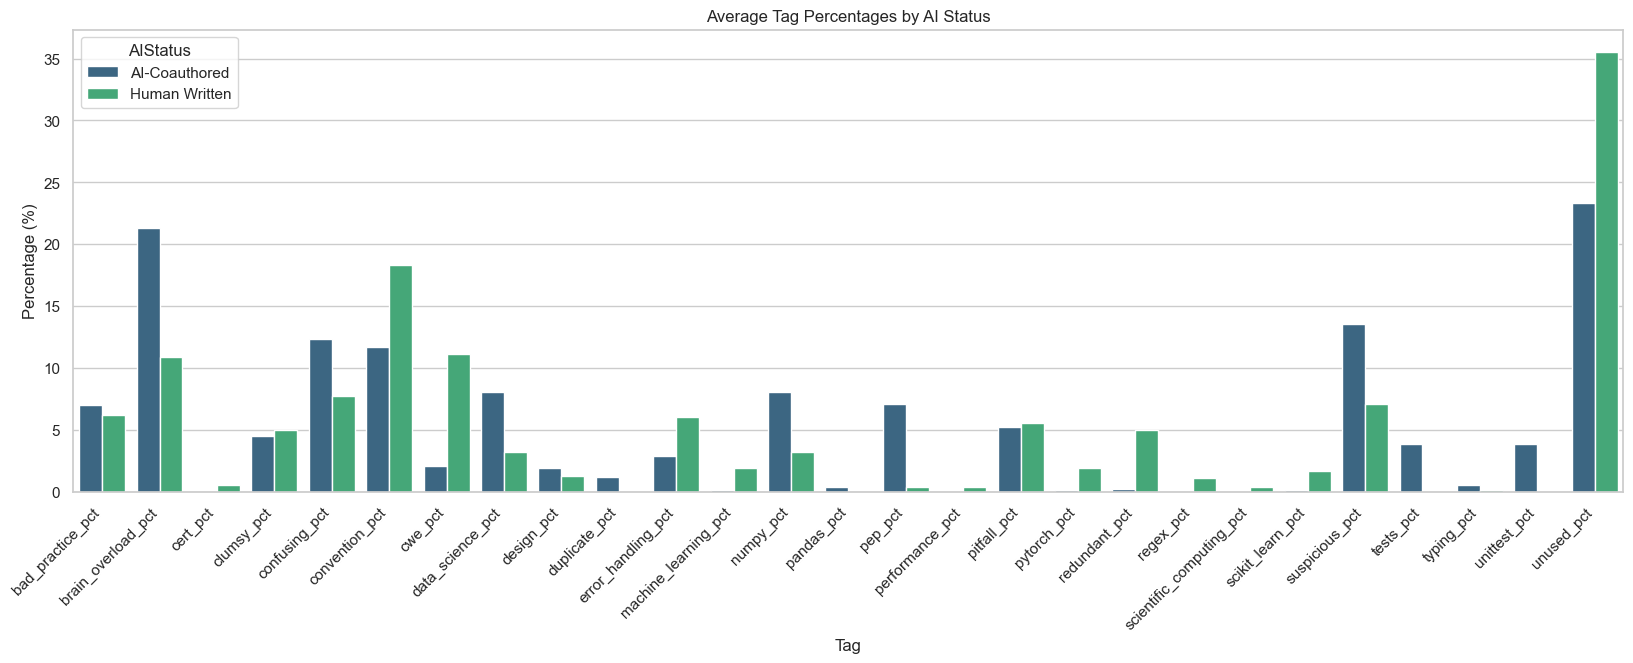


Analysis complete.


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import statsmodels.formula.api as smf
from tabulate import tabulate
from statsmodels.stats.multitest import multipletests

def main():
    # Create an output directory for charts
  
    
    # Read CSV Data
    df = pd.read_csv('/Users/prateekbalani/Downloads/code_smells_comparison_report_final_result.csv')
    
    
    # Rename columns if they differ
    df.rename(columns={
        'AI Status': 'AIStatus',
        'ncloc': 'Loc',
        'Number of Commits': 'Commits',
        'Total Code Smells': 'TotalSmells',
        'bad-practice': 'bad_practice',
        'brain-overload': 'brain_overload',
        'data-science': 'data_science',
        'error-handling': 'error_handling',
        'machine-learning': 'machine_learning',
        'scientific-computing': 'scientific_computing',
        'scikit-learn': 'scikit_learn',
        
    }, inplace=True)
    
    
   
    
    # Create a binary variable for AI coauthorship (1 = AI, 0 = Human)
    df['AI_Binary'] = df['AIStatus'].apply(lambda x: 1 if 'AI' in str(x) else 0)

    base_cols = ['Repository', 'Repository URL', 'AIStatus', 'Loc', 'Commits', 
                 'TotalSmells', 'AI_Binary']
    tag_cols = [col for col in df.columns if col not in base_cols and pd.api.types.is_numeric_dtype(df[col])]

     # For each tag column, calculate its percentage relative to TotalSmells
    for col in tag_cols:
        df[col + '_pct'] = df.apply(lambda row: (row[col] / row['TotalSmells'] * 100)
                                     if row['TotalSmells'] > 0 else np.nan, axis=1)
        
     # List of percentage columns for the tags
    pct_tag_cols = [col + '_pct' for col in tag_cols]
    
    # Descriptive Statistics by AI status
    grouped = df.groupby('AIStatus')[pct_tag_cols]
    desc_stats = grouped.agg(['mean', 'median', 'std', 'count'])
    print("\nDescriptive Statistics by AI Status:\n", desc_stats)
    
    summary_data = []
    # Mann–Whitney U Test on one tag percentage column (for example, the first one)
    for tag in pct_tag_cols:
        ai_group = df[df['AI_Binary'] == 1][tag].dropna()
        human_group = df[df['AI_Binary'] == 0][tag].dropna()
        if len(ai_group) > 0 and len(human_group) > 0:
            stat, p_value = mannwhitneyu(ai_group, human_group, alternative='two-sided')
            print(f"\nMann-Whitney U test for {tag}:")
            print(f"Statistic = {stat:.4f}, p-value = {p_value:.4g}")

            # Add to summary list
            summary_data.append({
                'Smell Tag': tag.replace('_pct', '').replace('_', ' ').title(),
                'Mean (AI)': round(ai_group.mean(), 2),
                'Mean (Human)': round(human_group.mean(), 2),
                'Difference (AI - Human)': round(ai_group.mean() - human_group.mean(), 2),
                'p-value': round(p_value, 4)
            })

        else:
            print(f"\nNot enough data to run Mann-Whitney U test for {tag}.")

# Create and display summary table
    summary_df = pd.DataFrame(summary_data)
    
    # Apply Benjamini–Hochberg correction over the p-values if there is any data
    if not summary_df.empty:
        pvals = summary_df['p-value'].values
        rejected, corrected_pvals, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
        summary_df['Corrected p-value'] = np.round(corrected_pvals, 4)
        summary_df['Significant'] = ['Yes' if r else 'No' for r in rejected]

    # Clean up column names for display
    clean_table = summary_df[['Smell Tag', 'p-value','Corrected p-value']]
    clean_table = clean_table.round(2)

    # Convert to string table
    table_str = tabulate(clean_table, headers='keys', tablefmt='fancy_grid')
    print("\nSmell Comparison Summary:\n")
    print(table_str)
   
    
    # Grouped Bar Chart for Tag Percentages by AI Status
    if pct_tag_cols:
        tag_means = df.groupby('AIStatus')[pct_tag_cols].mean().reset_index()
        tag_means_melt = tag_means.melt(id_vars='AIStatus', var_name='Tag', value_name='AvgPercentage')
    
        plt.figure(figsize=(20,6))
        sns.barplot(x='Tag', y='AvgPercentage', hue='AIStatus', data=tag_means_melt, palette='viridis')
        plt.title('Average Tag Percentages by AI Status')
        plt.ylabel('Percentage (%)')
        plt.xticks(rotation=45, ha='right')
        plt.show()
    else:
        print("\nNo tag columns found to plot tag percentages.")
    
    
    
    print("\nAnalysis complete.")


if __name__ == '__main__':
    main()